In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv("HR-Employee-Attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Gereksiz Sütunları Kaldırma
drop_cols = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']
df = df.drop(columns=drop_cols)
# EmployeeNumber → Benzersiz ID
# EmployeeCount → Hepsi 1 (yani gereksiz)
# Over18 → Hepsi Y (yani gereksiz)
# StandardHours → Hepsi 80 (yani gereksiz)

In [4]:
# Veri yapısı
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [5]:
# Eksik Değer Kontrolü
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [6]:
# Kategorik Değişkenler
kategorik = df.select_dtypes(include='object')
print("Kategorik değişkenler:", kategorik.columns.tolist())

Kategorik değişkenler: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


In [7]:
# Sayısal Değişkenler
sayisal = df.select_dtypes(include='number')
print("Sayısal değişkenler:", sayisal.columns.tolist())

Sayısal değişkenler: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [8]:
# Attrition Değişkenini Label Encode Etme
# Yes ve No olduğu için binary hale getirdik
lb = LabelEncoder()
df['Attrition'] = lb.fit_transform(df['Attrition'])

# Kategorik Verileri Encode Etme
df = pd.get_dummies(df, columns=kategorik.columns.drop(["Attrition"]), drop_first=True)

# Sayısal Verileri Ölçekleme
scaler = StandardScaler()
scaled_columns = ['Age', 'MonthlyIncome', 'YearsAtCompany',
                  "DailyRate","HourlyRate","MonthlyRate",
                  "PercentSalaryHike","DistanceFromHome",
                  "Education","EnvironmentSatisfaction",
                  "NumCompaniesWorked","TotalWorkingYears",
                  "YearsInCurrentRole","YearsSinceLastPromotion"]
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])

In [9]:
df # Bütün işlemeri yaptıktan sonra veri setimizi kontrol ediyoruz

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0.446350,1,0.742527,-1.010909,-0.891688,-0.660531,1.383138,3,2,4,...,False,False,False,False,False,True,False,False,True,True
1,1.322365,0,-1.297775,-0.147150,-1.868426,0.254625,-0.240677,2,2,2,...,False,False,False,False,True,False,False,True,False,False
2,0.008343,1,1.414363,-0.887515,-0.891688,1.169781,1.284725,2,1,3,...,True,False,False,False,False,False,False,False,True,True
3,-0.429664,0,1.461466,-0.764121,1.061787,1.169781,-0.486709,3,1,3,...,False,False,False,False,True,False,False,True,False,True
4,-1.086676,0,-0.524295,-0.887515,-1.868426,-1.575686,-1.274014,3,1,2,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.101159,0,0.202082,1.703764,-0.891688,0.254625,-1.224807,4,2,4,...,True,False,False,False,False,False,False,True,False,False
1466,0.227347,0,-0.469754,-0.393938,-1.868426,1.169781,-1.175601,2,3,1,...,False,False,False,False,False,False,False,True,False,False
1467,-1.086676,0,-1.605183,-0.640727,0.085049,-0.660531,1.038693,4,2,2,...,False,False,True,False,False,False,False,True,False,True
1468,1.322365,0,0.546677,-0.887515,0.085049,1.169781,-0.142264,2,2,2,...,False,False,False,False,False,True,False,True,False,False


In [10]:
X = df.drop(columns=["Attrition"])
y = df['Attrition']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [12]:
reports = [] # Daha sonrasında modelleri karşılaştırmak için liste oluşturduk

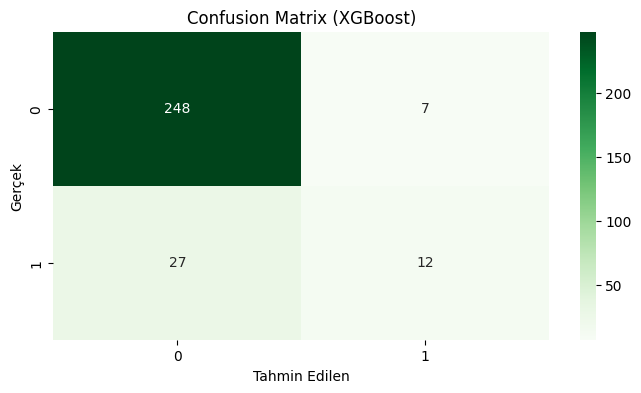

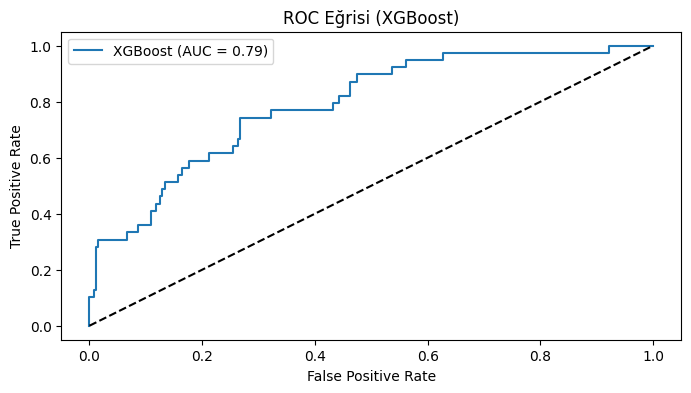

ROC AUC: 0.7886


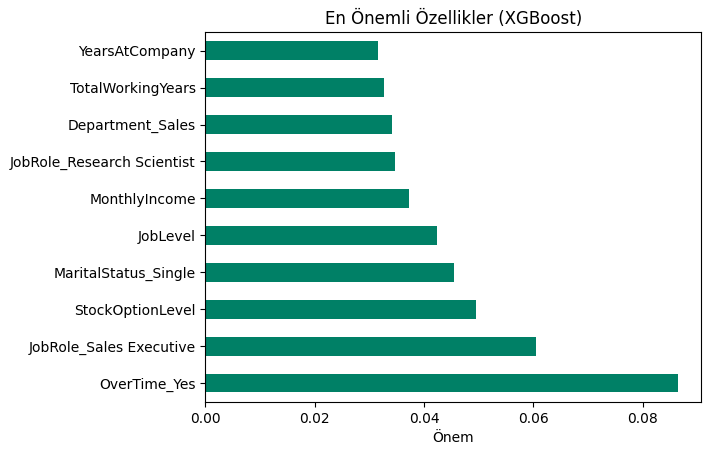

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       255
           1       0.63      0.31      0.41        39

    accuracy                           0.88       294
   macro avg       0.77      0.64      0.67       294
weighted avg       0.87      0.88      0.87       294



In [13]:
# Modeli eğitmek, tahmin yapmak, değerlendirmek (XGBoost)

# Modeli Eğitme
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Test Verisinde Tahmin Yapma
y_pred = xgb_model.predict(X_test)

# Değerlendirme
confusionMatrix = confusion_matrix(y_test, y_pred)
classReport = classification_report(y_test, y_pred)
reports.append(classification_report(y_test, y_pred,output_dict=True))
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rocScore = roc_auc_score(y_test, y_pred_prob)

# Confusion Matrix Çizme
plt.figure(figsize=(8,4))
sns.heatmap(confusionMatrix,annot=True,fmt="d",cmap="Greens")
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# ROC Eğrisini Çizme
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {rocScore:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi (XGBoost)')
plt.legend()
plt.show()

print(f"ROC AUC: {rocScore:.4f}")

# En Önemli Özellikleri Belirtme
importances = xgb_model.feature_importances_
features = X.columns
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False).head(10)
feat_importance.plot(kind='barh',cmap="summer")
plt.title(f"En Önemli Özellikler (XGBoost)")
plt.xlabel("Önem")
plt.show()

#Raporu Gösterme
print(classReport)

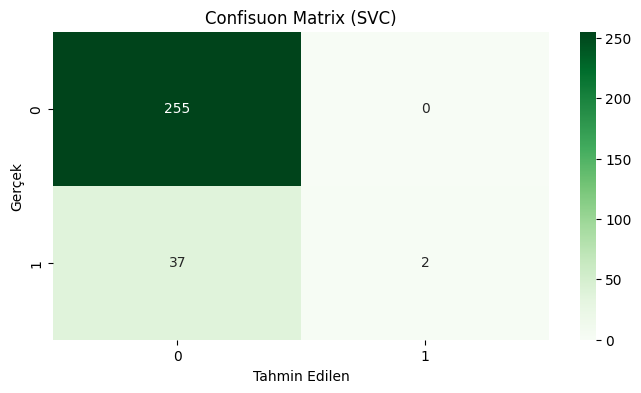

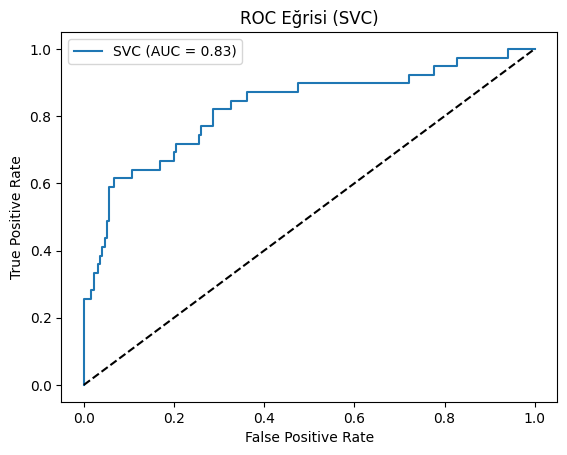

ROC AUC: 0.8257
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       255
           1       1.00      0.05      0.10        39

    accuracy                           0.87       294
   macro avg       0.94      0.53      0.51       294
weighted avg       0.89      0.87      0.82       294



In [14]:
# Modeli eğitmek, tahmin yapmak, değerlendirmek (SVC)

# Modeli Eğitme
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)

# Test Verisinde Tahmin Yapma
y_pred = svc_model.predict(X_test)

# Değerlendirme
confisionMatrix = confusion_matrix(y_test, y_pred)
classReport = classification_report(y_test, y_pred,zero_division=True)
reports.append(classification_report(y_test, y_pred,zero_division=True,output_dict=True))
y_proba = svc_model.predict_proba(X_test)[:, 1]  # Pozitif sınıfın olasılıkları
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
rocScore = roc_auc_score(y_test, y_proba)

# Confusion Matrix Çizme
plt.figure(figsize=(8,4))
sns.heatmap(confisionMatrix,annot=True,fmt="d",cmap="Greens")
plt.title("Confisuon Matrix (SVC)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# ROC Eğrisini Çizme
plt.plot(fpr, tpr, label=f'SVC (AUC = {rocScore:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi (SVC)')
plt.legend()
plt.show()

print(f"ROC AUC: {rocScore:.4f}")

#Raporu Gösterme
print(classReport)

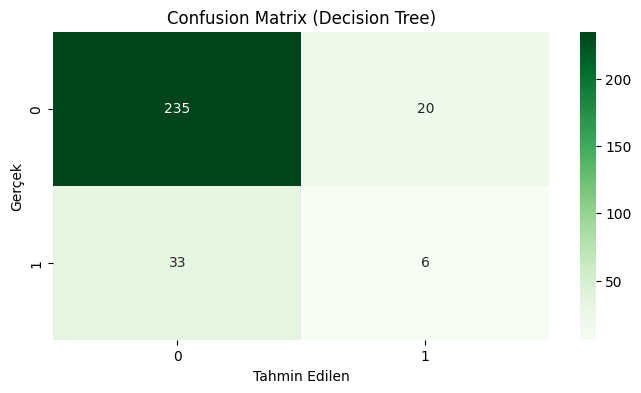

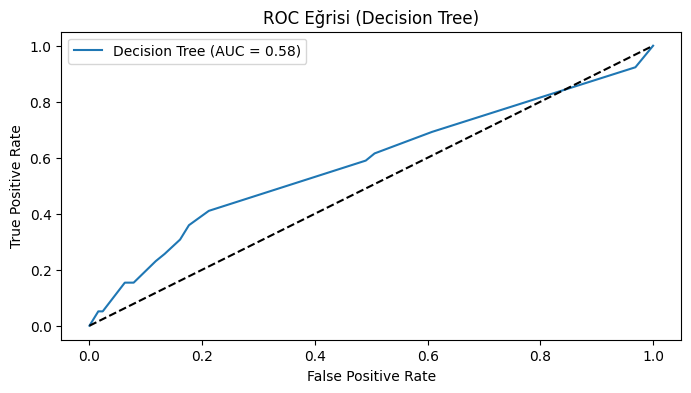

ROC AUC: 0.5821


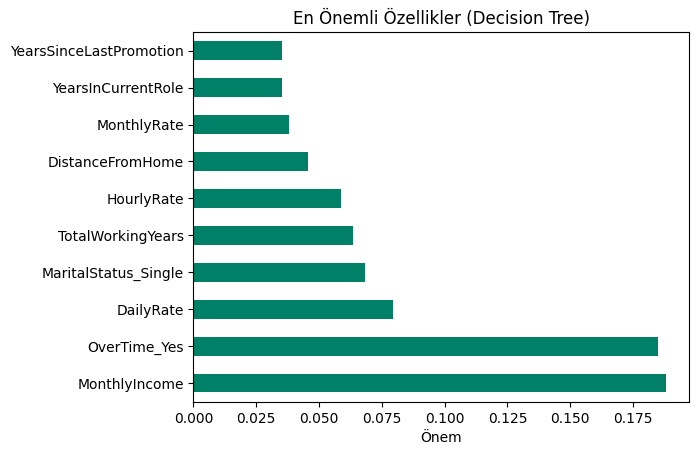

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       255
           1       0.23      0.15      0.18        39

    accuracy                           0.82       294
   macro avg       0.55      0.54      0.54       294
weighted avg       0.79      0.82      0.80       294



In [15]:
# Modeli eğitmek, tahmin yapmak, değerlendirmek (Decision Tree)

# Modeli Eğitme
decT_model = DecisionTreeClassifier(max_depth=5,min_samples_split=10) # Performansı arttırmak için
decT_model.fit(X_train, y_train)

# Test Verisinde Tahmin Yapma
y_pred = decT_model.predict(X_test)

# Değerlendirme
confusionMatrix = confusion_matrix(y_test, y_pred)
classReport = classification_report(y_test, y_pred)
reports.append(classification_report(y_test, y_pred,output_dict=True))
y_pred_prob = decT_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rocScore = roc_auc_score(y_test, y_pred_prob)

# Confusion Matrix Çizme
plt.figure(figsize=(8,4))
sns.heatmap(confusionMatrix,annot=True,fmt="d",cmap="Greens")
plt.title("Confusion Matrix (Decision Tree)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# ROC Eğrisini Çizme
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {rocScore:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi (Decision Tree)')
plt.legend()
plt.show()

print(f"ROC AUC: {rocScore:.4f}")

# En Önemli Özellikleri Belirtme
importances = decT_model.feature_importances_
features = X.columns
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False).head(10)
feat_importance.plot(kind='barh',cmap="summer")
plt.title(f"En Önemli Özellikler (Decision Tree)")
plt.xlabel("Önem")
plt.show()

#Raporu Gösterme
print(classReport)

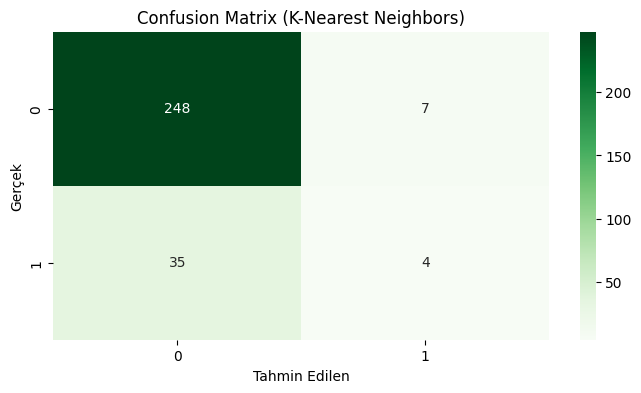

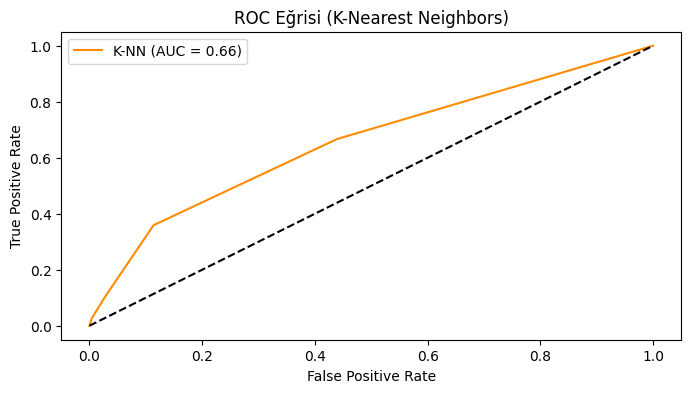


ROC AUC: 0.6557
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       255
           1       0.36      0.10      0.16        39

    accuracy                           0.86       294
   macro avg       0.62      0.54      0.54       294
weighted avg       0.81      0.86      0.82       294



In [16]:
# Modeli eğitmek, tahmin yapmak, değerlendirmek (K-Nearest Neighbors)

# Modeli Eğitme
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Test Verisinde Tahmin Yapma
y_pred = knn_model.predict(X_test)

# Değerlendirme
confusionMatrix = confusion_matrix(y_test, y_pred)
classReport = classification_report(y_test, y_pred, zero_division=True)
reports.append(classification_report(y_test, y_pred, zero_division=True,output_dict=True))
y_proba = knn_model.predict_proba(X_test)[:, 1]  # Pozitif sınıfın olasılıkları
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
rocScore = roc_auc_score(y_test, y_proba)

# Confusion Matrix Çizme
plt.figure(figsize=(8,4))
sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix (K-Nearest Neighbors)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# ROC Eğrisini Görselleştirme
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, label=f'K-NN (AUC = {rocScore:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi (K-Nearest Neighbors)')
plt.legend()
plt.show()

print(f"\nROC AUC: {rocScore:.4f}")

# Raporu Gösterme
print(classReport)

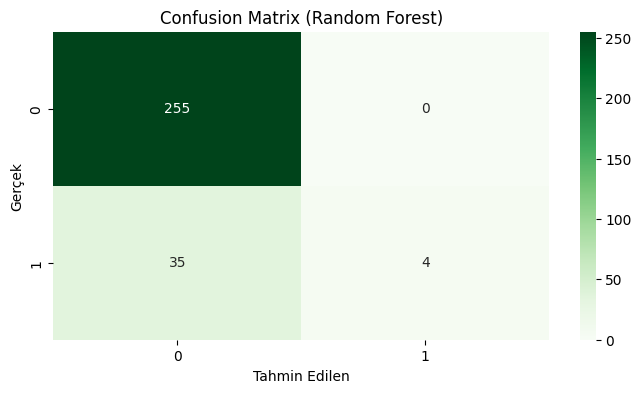

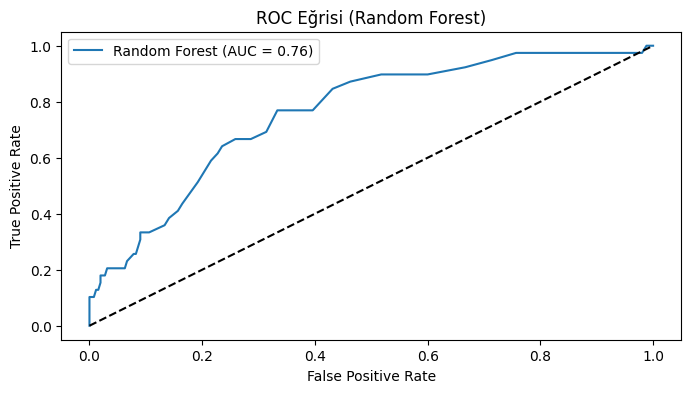

ROC AUC: 0.7594


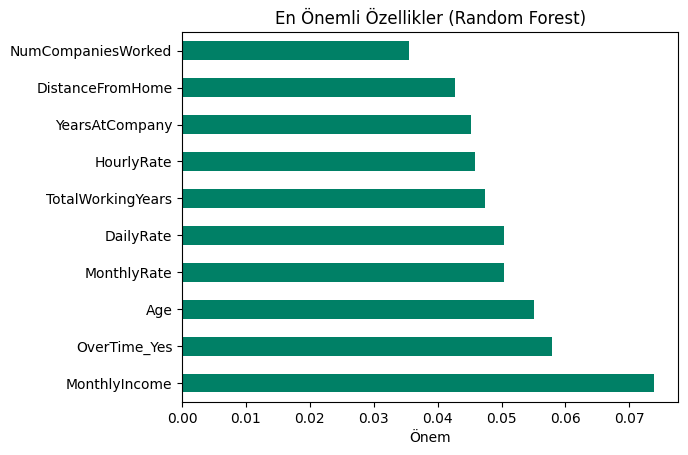

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       255
           1       1.00      0.10      0.19        39

    accuracy                           0.88       294
   macro avg       0.94      0.55      0.56       294
weighted avg       0.90      0.88      0.84       294



In [17]:
# Modeli eğitmek, tahmin yapmak, değerlendirmek (Random Forest)

# Modeli Eğitme
rndF_model = RandomForestClassifier()
rndF_model.fit(X_train, y_train)

# Test Verisinde Tahmin Yapma
y_pred = rndF_model.predict(X_test)

# Değerlendirme
confusionMatrix = confusion_matrix(y_test, y_pred)
classReport = classification_report(y_test, y_pred)
reports.append(classification_report(y_test, y_pred,output_dict=True))
y_pred_prob = rndF_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rocScore = roc_auc_score(y_test, y_pred_prob)

# Confusion Matrix Çizme
plt.figure(figsize=(8,4))
sns.heatmap(confusionMatrix,annot=True,fmt="d",cmap="Greens")
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# ROC Eğrisini Çizme
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rocScore:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi (Random Forest)')
plt.legend()
plt.show()

print(f"ROC AUC: {rocScore:.4f}")

# En Önemli Özellikleri Belirtme
importances = rndF_model.feature_importances_
features = X.columns
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False).head(10)
feat_importance.plot(kind='barh',cmap="summer")
plt.title(f"En Önemli Özellikler (Random Forest)")
plt.xlabel("Önem")
plt.show()

#Raporu Gösterme
print(classReport)

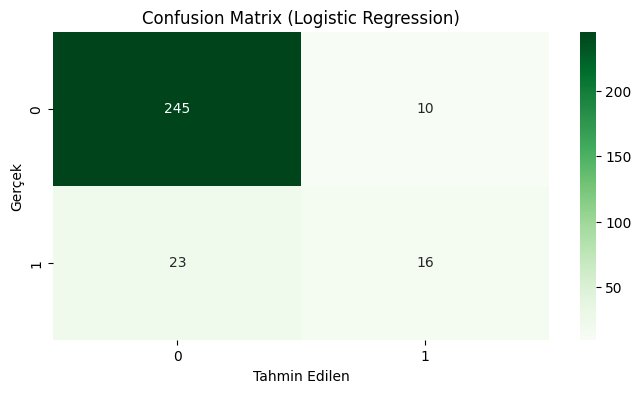

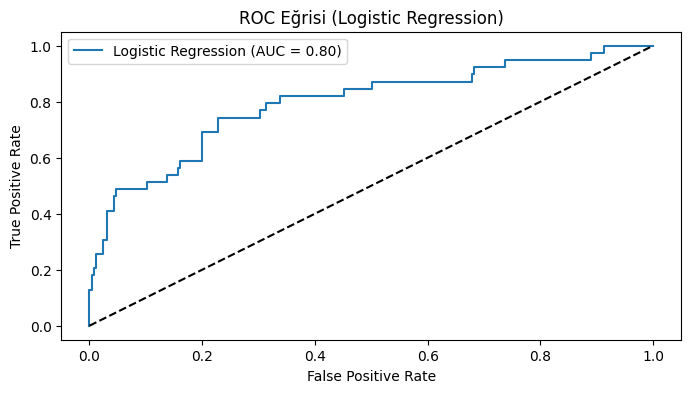

ROC AUC: 0.7958
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       255
           1       0.62      0.41      0.49        39

    accuracy                           0.89       294
   macro avg       0.76      0.69      0.71       294
weighted avg       0.87      0.89      0.88       294



In [18]:
# Modeli eğitmek, tahmin yapmak, değerlendirmek (Logistic Regression)

# Modeli Eğitme
log_model = LogisticRegression(max_iter=8500,solver="saga",fit_intercept=True)
# model.n_iter_ ile kontrol yaptık 7930 çıkıyor %10da pay verdik o yüzden 8500 iter yaptık
# solver = "saga" ise saga daha büyük veri setlerinde olduğu için
log_model.fit(X_train, y_train)

# Test Verisinde Tahmin Yapma
y_pred = log_model.predict(X_test)

# Değerlendirme
confusionMatrix = confusion_matrix(y_test, y_pred)
classReport = classification_report(y_test, y_pred,zero_division=True)
reports.append(classification_report(y_test, y_pred,zero_division=True,output_dict=True))
y_pred_prob = log_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rocScore = roc_auc_score(y_test, y_pred_prob)

# Confusion Matrix Çizme
plt.figure(figsize=(8,4))
sns.heatmap(confusionMatrix,annot=True,fmt="d",cmap="Greens")
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# ROC Eğrisini Çizme
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {rocScore:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi (Logistic Regression)')
plt.legend()
plt.show()

print(f"ROC AUC: {rocScore:.4f}")

#Raporu Gösterme
print(classReport)

In [19]:
def predict_attrition(model, employee_data, feature_columns, scaler, scaled_cols):
    """
    Verilen modele göre bir çalışanın işten ayrılıp ayrılmayacağını tahmin eder.
    
    Params:
        model: Eğitilmiş model (RandomForest, XGBoost, vb.)
        employee_data: dict, çalışanın özellikleri (One-Hot + sayısallar)
        feature_columns: Modelin beklediği tüm sütun isimleri (X.columns)
        scaler: Eğitilmiş StandardScaler
        scaled_cols: Sadece scale edilecek sayısal sütunlar
    
    Returns:
        Tahmin sonucu ('Ayrılacak' veya 'Ayrılmayacak') ve olasılık (float)
    """
    # Tüm sütunları sıfır olan bir satır oluştur
    new_data = pd.DataFrame(columns=feature_columns)
    new_data.loc[0] = 0

    # Kullanıcının verdiği verileri yerleştir
    for key, value in employee_data.items():
        if key in new_data.columns:
            new_data.at[0, key] = value
        else:
            print(f"⚠️ Uyarı: '{key}' modelin beklediği sütunlarda yok, atlandı.")

    # Sayısal sütunları scale et
    new_data[scaled_cols] = scaler.transform(new_data[scaled_cols])

    # Tahmin
    prediction = model.predict(new_data)[0]
    probability = model.predict_proba(new_data)[0][1]

    result_text = "İşten Ayrılacak" if prediction == 1 else "İşten Ayrılmayacak"
    return result_text, probability


In [20]:
employee_input = {
    'Age': 45,
    'MonthlyIncome': 11000,
    'YearsAtCompany': 10,
    'MaritalStatus_Married': 1,
    'JobRole_Research Scientist': 1,
    'EducationField_Life Sciences': 1,
    'JobSatisfaction': 4,
    'WorkLifeBalance': 4,
    # Diğer sütunlar modelde varsa (örneğin One-Hot sütunları) sıfır kalabilir
}

models = [xgb_model,svc_model,decT_model,knn_model,rndF_model,log_model]

for model in models:
    result, prob = predict_attrition(model, employee_input, X.columns, scaler, scaled_columns)
    print(f"{model.__class__.__name__ }: {result} ({prob:.2%} olasılıkla)")

XGBClassifier: İşten Ayrılmayacak (36.88% olasılıkla)
SVC: İşten Ayrılmayacak (74.98% olasılıkla)
DecisionTreeClassifier: İşten Ayrılacak (100.00% olasılıkla)
KNeighborsClassifier: İşten Ayrılmayacak (40.00% olasılıkla)
RandomForestClassifier: İşten Ayrılmayacak (30.00% olasılıkla)
LogisticRegression: İşten Ayrılmayacak (32.21% olasılıkla)


In [21]:
processed_reports = []

for model_name, report in zip(models, reports):
    # Geçici DataFrame oluştur
    df_temp = pd.DataFrame(report).transpose().reset_index()
    
    # Sütun isimlerini düzenle
    df_temp.columns = ['Class', 'Precision', 'Recall', 'F1-Score', 'Support'] 
    
    # Model ismini ekle
    df_temp.insert(0, 'Model', model_name.__class__.__name__)
    
    processed_reports.append(df_temp)

# Tüm raporları tek DataFrame'de birleştir
final_df_temp = pd.concat(processed_reports)

# Sonucu göster
final_df_temp

,Model,Class,Precision,Recall,F1-Score,Support
0,XGBClassifier,0,0.901818,0.972549,0.935849,255.000000
1,XGBClassifier,1,0.631579,0.307692,0.413793,39.000000
2,XGBClassifier,accuracy,0.884354,0.884354,0.884354,0.884354
3,XGBClassifier,macro avg,0.766699,0.640121,0.674821,294.000000
4,XGBClassifier,weighted avg,0.865970,0.884354,0.866597,294.000000
0,SVC,0,0.873288,1.000000,0.932358,255.000000
1,SVC,1,1.000000,0.051282,0.097561,39.000000
2,SVC,accuracy,0.874150,0.874150,0.874150,0.874150
3,SVC,macro avg,0.936644,0.525641,0.514960,294.000000
4,SVC,weighted avg,0.890096,0.874150,0.821620,294.000000
